In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/train.zip"
test_path = "/content/drive/MyDrive/Colab Notebooks/test1.zip"
files = "/content/working/"

import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)

with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [ ]:
filenames=os.listdir("./working/train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [ ]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=64

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./working/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./working/train/",
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./working/test/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 20000 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
epochs=10
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-10-0303d50756ed>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
312/312 [==============================] - ETA: 0s - loss: 0.7935 - accuracy: 0.6371

312/312 [==============================] - 1082s 3s/step - loss: 0.7935 - accuracy: 0.6371 - val_loss: 1.2305 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 2/10
312/312 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7245

312/312 [==============================] - 1069s 3s/step - loss: 0.5639 - accuracy: 0.7245 - val_loss: 0.4823 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 3/10
312/312 [==============================] - ETA: 0s - loss: 0.5018 - accuracy: 0.7607

312/312 [==============================] - 1077s 3s/step - loss: 0.5018 - accuracy: 0.7607 - val_loss: 0.8065 - val_accuracy: 0.6146 - lr: 0.0010
Epoch 4/10
312/312 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.7793

312/312 [==============================] - 1076s 3s/step - loss: 0.4680 - accuracy: 0.7793 - val_loss: 0.3869 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 5/10
312/312 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.8013

312/312 [==============================] - 1055s 3s/step - loss: 0.4346 - accuracy: 0.8013 - val_loss: 0.3777 - val_accuracy: 0.8329 - lr: 0.0010
Epoch 6/10
312/312 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8136

312/312 [==============================] - 1057s 3s/step - loss: 0.4070 - accuracy: 0.8136 - val_loss: 0.6023 - val_accuracy: 0.7198 - lr: 0.0010
Epoch 7/10
312/312 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8298

312/312 [==============================] - 1023s 3s/step - loss: 0.3837 - accuracy: 0.8298 - val_loss: 0.5454 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 8/10
312/312 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8393

312/312 [==============================] - 1036s 3s/step - loss: 0.3622 - accuracy: 0.8393 - val_loss: 0.2935 - val_accuracy: 0.8744 - lr: 0.0010
Epoch 9/10
312/312 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8481

312/312 [==============================] - 1049s 3s/step - loss: 0.3494 - accuracy: 0.8481 - val_loss: 0.3211 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 10/10
312/312 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8546

312/312 [==============================] - 1044s 3s/step - loss: 0.3348 - accuracy: 0.8546 - val_loss: 0.7259 - val_accuracy: 0.7310 - lr: 0.0010


In [ ]:
model.save("model1_catsVSdogs_10epoch.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


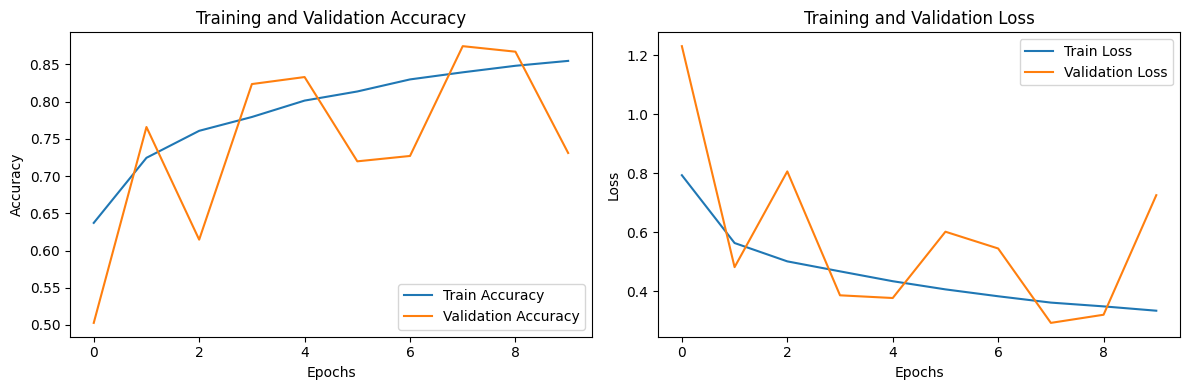

In [30]:
# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ biểu đồ mất mát
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 29ms/step


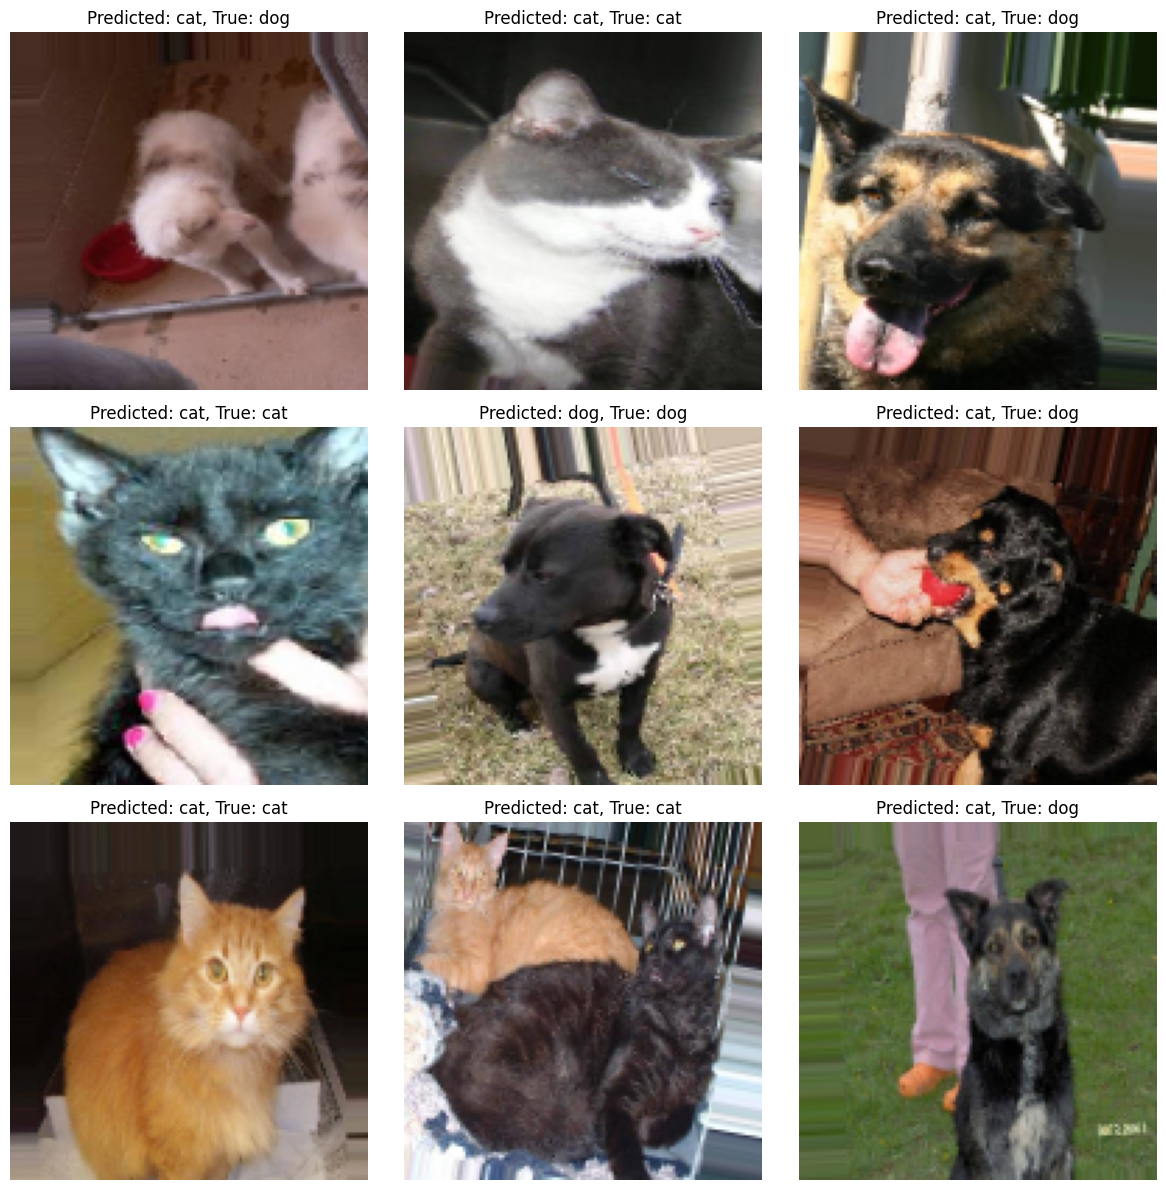

In [45]:
label_map = {0: 'cat', 1: 'dog'}

# Lấy 9 hình ảnh ngẫu nhiên và dự đoán
def display_random_images_with_predictions(generator, model, num_images=9):
    # Lấy một batch hình ảnh
    x_batch, y_batch = next(generator)

    # Chọn ngẫu nhiên các hình ảnh từ batch
    random_indices = np.random.choice(len(x_batch), num_images, replace=False)
    random_images = x_batch[random_indices]
    true_labels = y_batch[random_indices]

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        img = random_images[i]
        img_expanded = np.expand_dims(img, axis=0)

        prediction = model.predict(img_expanded)
        predicted_class = np.argmax(prediction, axis=1)[0]
        true_class = np.argmax(true_labels[i])

        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f'Predicted: {label_map[predicted_class]}, True: {label_map[true_class]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Hiển thị 9 hình ảnh ngẫu nhiên với dự đoán
display_random_images_with_predictions(train_generator, model)
